In [1]:
from SymPT import *
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy.linalg as la

In [2]:
#plt.style.use("classic")
cmap = plt.get_cmap('inferno')
plt.rc('text', usetex = True)
plt.rc('font', family = 'serif', weight = 'normal')
plt.rc('font', size = 18)
color_list = [cmap(i) for i in np.linspace(0, 1, 16)]
fntsize = 20
dir_images = "graphs/"

# Hamiltonian

In [3]:
def substitution_rules(I, J, omegas, lambdas):
    """Returns 2 dictionaries containing substitution rules for H"""
    omega_values = np.sort([np.random.uniform(-10, 10) for _ in range(I)])  
    substitution_dict = {omegas[i]: omega_values[i] for i in range(I)}
    substitution_omegas = {omegas[i]: omega_values[i] for i in range(I)}

    lambda_index = 0
    for i in range(I):
        for j in range(i+1, J):  # Iterate only over the upper triangular part
            bound = 0.1**(lambdas[lambda_index].order) * abs(omega_values[i] - omega_values[j])            
            lambda_value = bound             
            substitution_dict[lambdas[lambda_index]] = lambda_value 
            lambda_index += 1
            
    return substitution_dict, substitution_omegas


In [4]:
def create_Hamiltonian(I, J):
    lambdas = [RDSymbol(f"\\lambda_{i}", order = 1, real = True) for i in range(int((I**2 -I))//2)]
    omegas = [RDSymbol(f"\\omega_{i}", order = 0, real = True) for i in range(I)]

    H = sp.zeros(I, J)
    lambda_index = 0
    for i in range(I):
        H[i, i] = omegas[i]  # Diagonal elements
        for j in range(i + 1, J):
            H[i, j] = lambdas[lambda_index]
            H[j, i] = lambdas[lambda_index]  # Ensure symmetry
            lambda_index += 1
    return H, omegas, lambdas

# Exact Block Diagonalization

In [5]:
def exact_block_diagonalization(Hh, mask):
    # Unitary transformation
    _, X = la.eigh(Hh)
    
    X_inv = np.linalg.inv(X)
    
    B_mask = lambda x: np.logical_not(mask) * 1 * x

    T = X @ B_mask(X_inv) @ la.fractional_matrix_power(B_mask(X) @ B_mask(X_inv), -1/2)

    return la.inv(T) @ Hh @ T


# Least Action Method

In [42]:
# Creating random block structure 
b_dims = np.random.randint(5, size=5)
structure = get_structure(b_dims)
mask = Block(structure)

# Creating random Hamiltonian
I, J = structure.shape
H, omegas, lambdas = create_Hamiltonian(I, J)
values, omegas_dict = substitution_rules(I,J, omegas, lambdas)

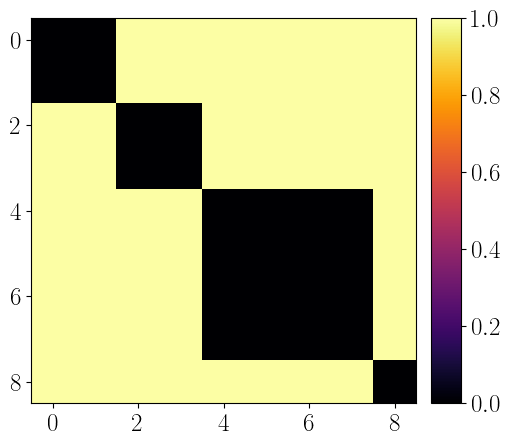

In [55]:
# Plotting
fig, ax = plt.subplots(figsize=(15, 5), dpi = 100)
im = ax.imshow(np.array(structure, dtype=float), cmap='inferno') # Initial Hamiltonian
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
fig.colorbar(im, cax=cax)
#plt.savefig('LA_mask.pdf',  bbox_inches='tight')

In [45]:
# Initializing effective frame
Eff_Frame = EffectiveFrame(H, symbol_values = values, verbose = True)

In [46]:
# Calculate the effective model using mask
max_order = 8 # perturbation order
Eff_Frame.solve(max_order = max_order, method = "LA", mask=mask)

# Obtaining the result in the matrix form
LA_result = Eff_Frame.get_H(return_form = "matrix")

Converting to matrix form: 100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 10660.47it/s]


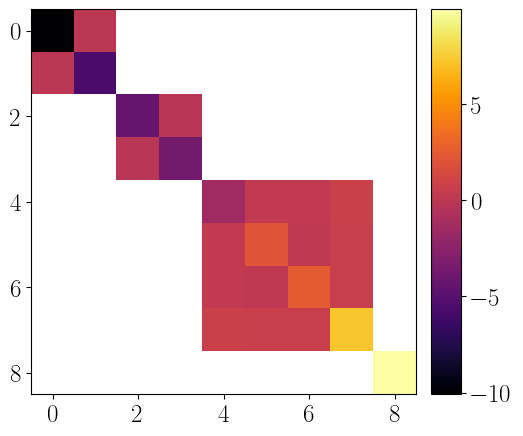

In [56]:
# Plotting
np_LA = np.array(LA_result,dtype=float)
np_LA[np.abs(np_LA) < 1e-13] = None # setting zero values to None
fig, ax = plt.subplots(figsize=(15, 5), dpi = 100)
im = ax.imshow(np.array(np_LA, dtype=float), cmap='inferno') # Initial Hamiltonian
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
fig.colorbar(im, cax=cax)
#plt.savefig('LA_masked_hamiltonian.pdf',  bbox_inches='tight')

In [48]:
# Obtainining initial Hamiltonian (with values) and exact bd transformation
Hh = np.array(H.subs(values), dtype=float)
exact_result = exact_block_diagonalization(Hh, structure)

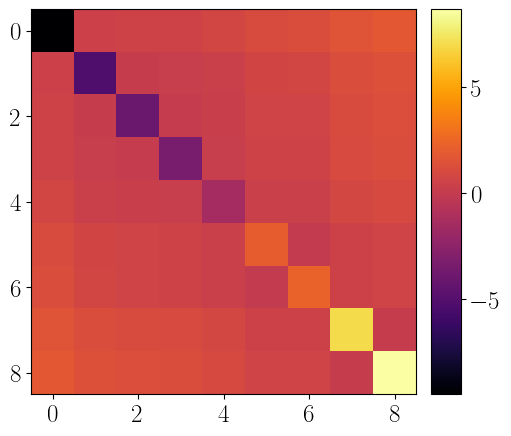

In [57]:
# Plotting
fig, ax = plt.subplots(figsize=(15, 5), dpi = 100)
im = ax.imshow(np.array(Hh, dtype=float), cmap='inferno') # Initial Hamiltonian
cax0 = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
fig.colorbar(im, cax=cax0)
#plt.savefig('LA_non_masked_hamiltonian.pdf',  bbox_inches='tight')

# Comparison with exact result

In [51]:
def fidelity(A, B):
    return np.linalg.norm(A - B) / np.linalg.norm(A)

In [52]:
LA_corrections = Eff_Frame.corrections # extracting order corrections from effective frame
error_order = [] # will store solutions to each order
LA_res = np.zeros_like(exact_result) # initializing result
for order in range(max_order + 1): 
    LA_res += np.array(LA_corrections.get(order, sp.zeros(*exact_result.shape)).evalf(), dtype=float) # correcting result with current order
    error_order.append(fidelity(exact_result, LA_res)) # append fidelity of current order

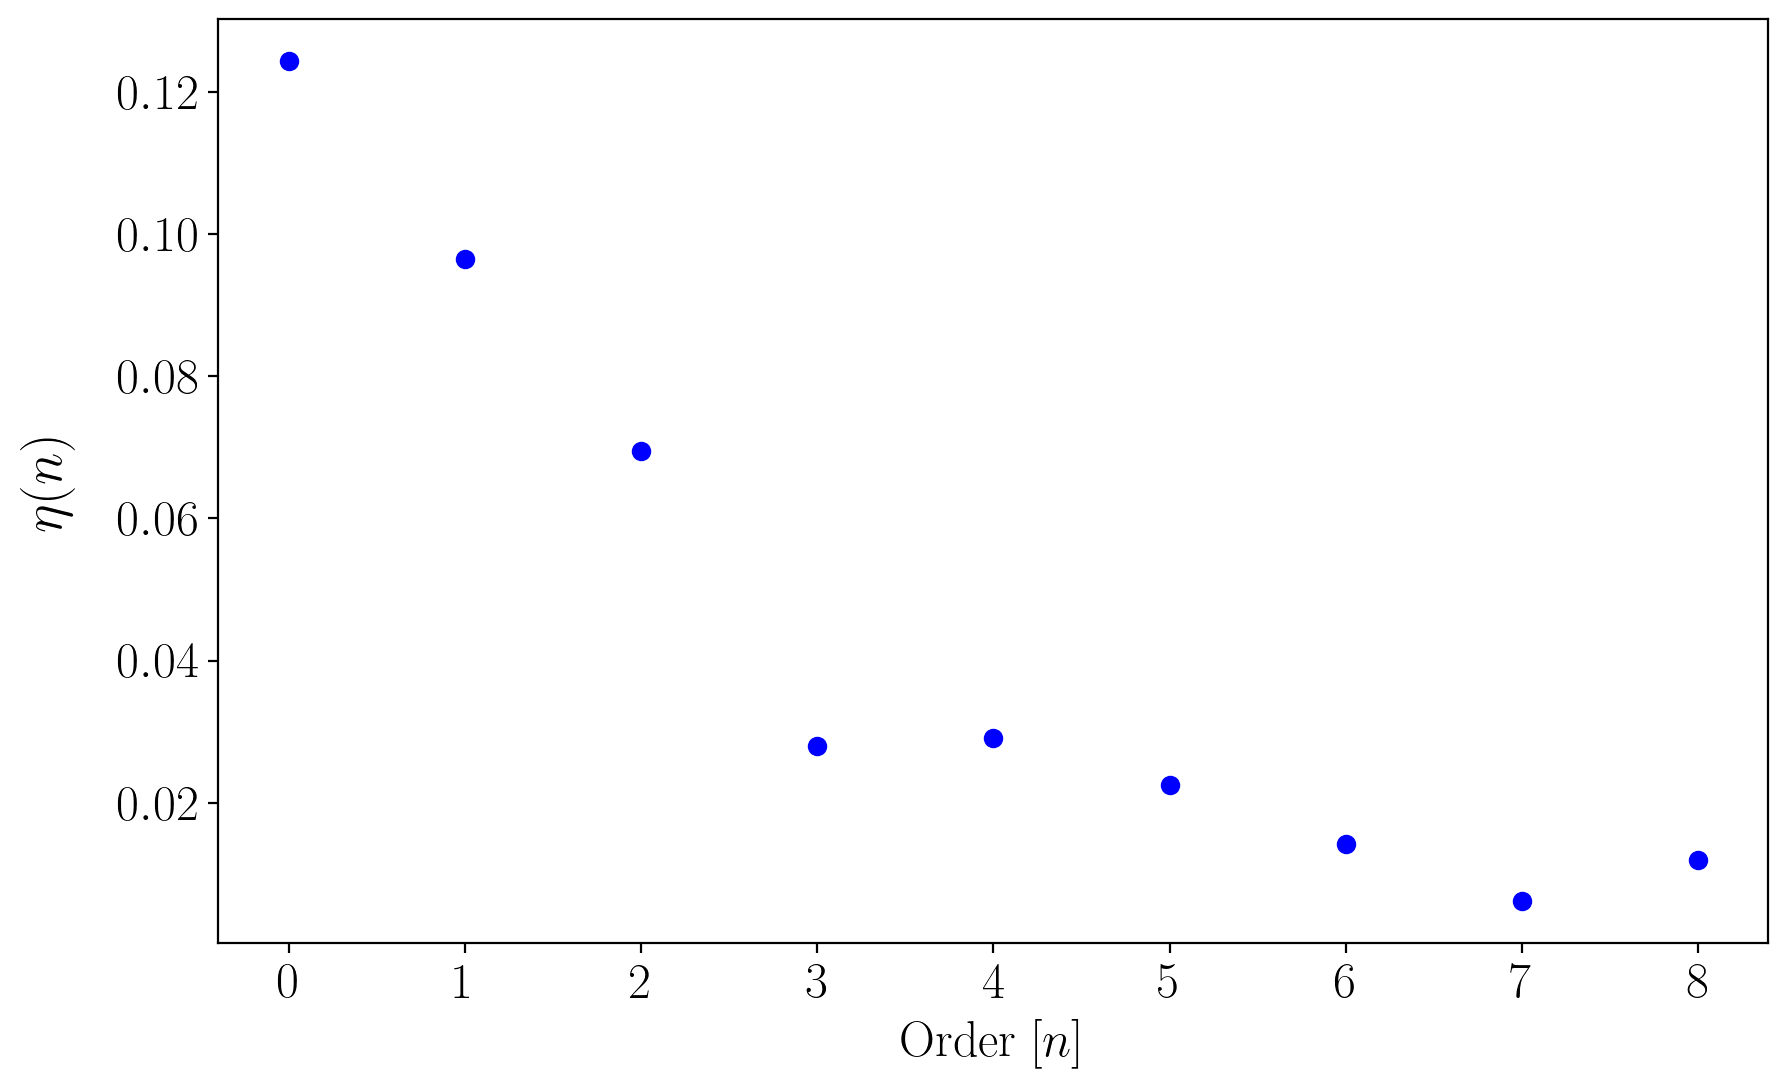

In [58]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6), dpi = 200)

ax.scatter(np.arange(0,max_order+1), error_order, color='blue')

ax.set_xlabel("Order $[n]$")
ax.set_ylabel(r"$\eta(n)$", fontsize=fntsize, labelpad=15)
#plt.savefig('LA_error_vs_order.pdf',  bbox_inches='tight')